# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

In [2]:
RANDOM_STATE = 12345

In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv')
    print('Загрузилось')
except:
    print('Ошибка при загрузке базы данных')

Загрузилось


In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<div style="border: 5px solid violet; border-radius: 5px;">
Приводим столбцы с датами к нужному типу и находим время продажи в днях. Чтобы быть уверенными, что цена адекватная/рыночная. Затем этот признак удалим, чтобы не было утечки.
</div>

In [6]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')
data['TimeOfSale'] = abs((data['DateCreated'] - data['LastSeen']).astype('timedelta64[D]')).astype('int')

In [7]:
# РЕВЬЮЕР ПОДШАМАНИЛ
data['TimeOfSale'] = abs((data['DateCreated'] - data['LastSeen']).values.astype('timedelta64[D]')).astype('int')

<div style="border: 5px solid violet; border-radius: 5px;">
Заменим `gasoline` на `petrol` - так как это одно и то же, но в разных странах.
</div>

In [8]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [9]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')

<div style="border: 5px solid violet; border-radius: 5px;">
Удалим дубликаты.
    
</div>

In [11]:
#sns.set(font_scale=5)
#sns.set(rc = {'figure.figsize':(50,50), 'ytick.labelsize': 25, 'xtick.labelsize': 25, 'axes.titlesize': 32})
# sns.heatmap(data.corr());
#sns.heatmap(data.corr(numeric_only=True));

In [12]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,TimeOfSale
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055,0.148219
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459,-0.000429
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665,0.020379
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698,-0.067890
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995,0.002898
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000,0.031016
TimeOfSale,0.148219,-0.000429,0.020379,-0.067890,0.002898,NaN,0.031016,1.000000


<div style="border: 5px solid violet; border-radius: 5px;">
Каких-либо явных корреляций мы не наблюдаем. Кроме слабовыраженной между ценой и километрами, что логично.  
</div>

<div style="border: 5px solid violet; border-radius: 5px;">
Очень грубо прикинем графики, чтобы посмотреть на выбросы, аномалии, распределения.
</div>

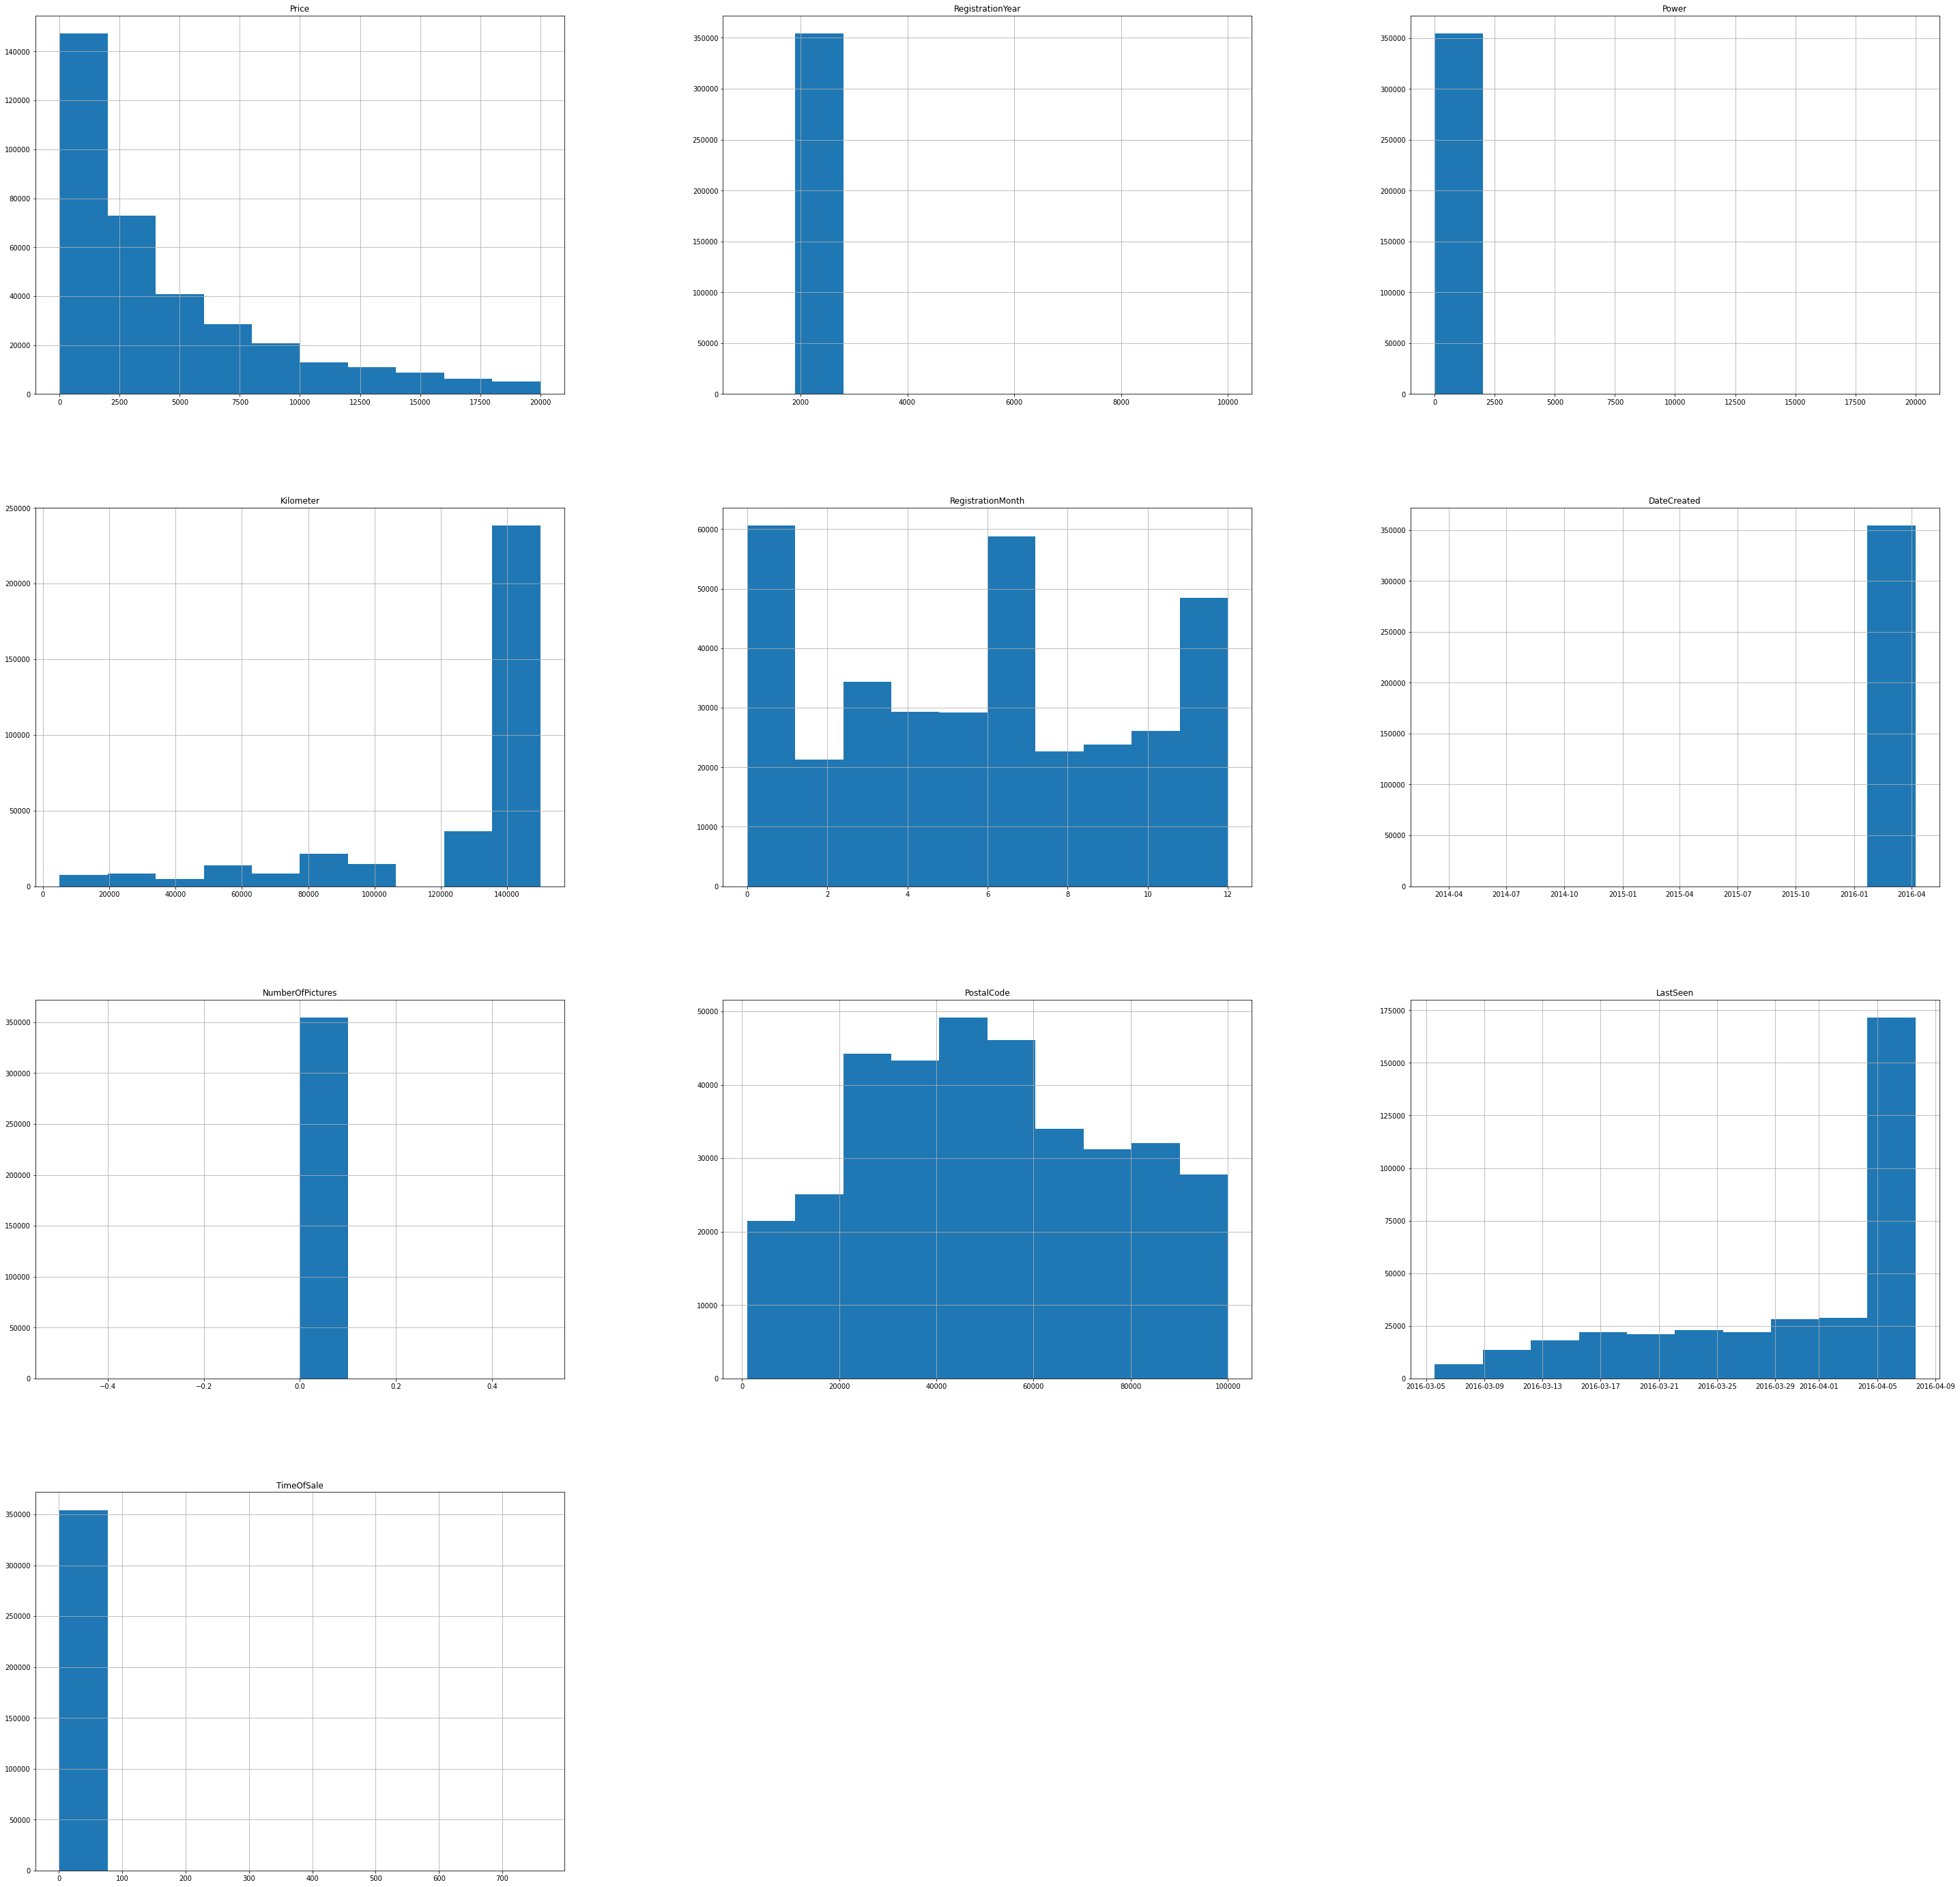

In [13]:
data.hist(figsize=(50,50));

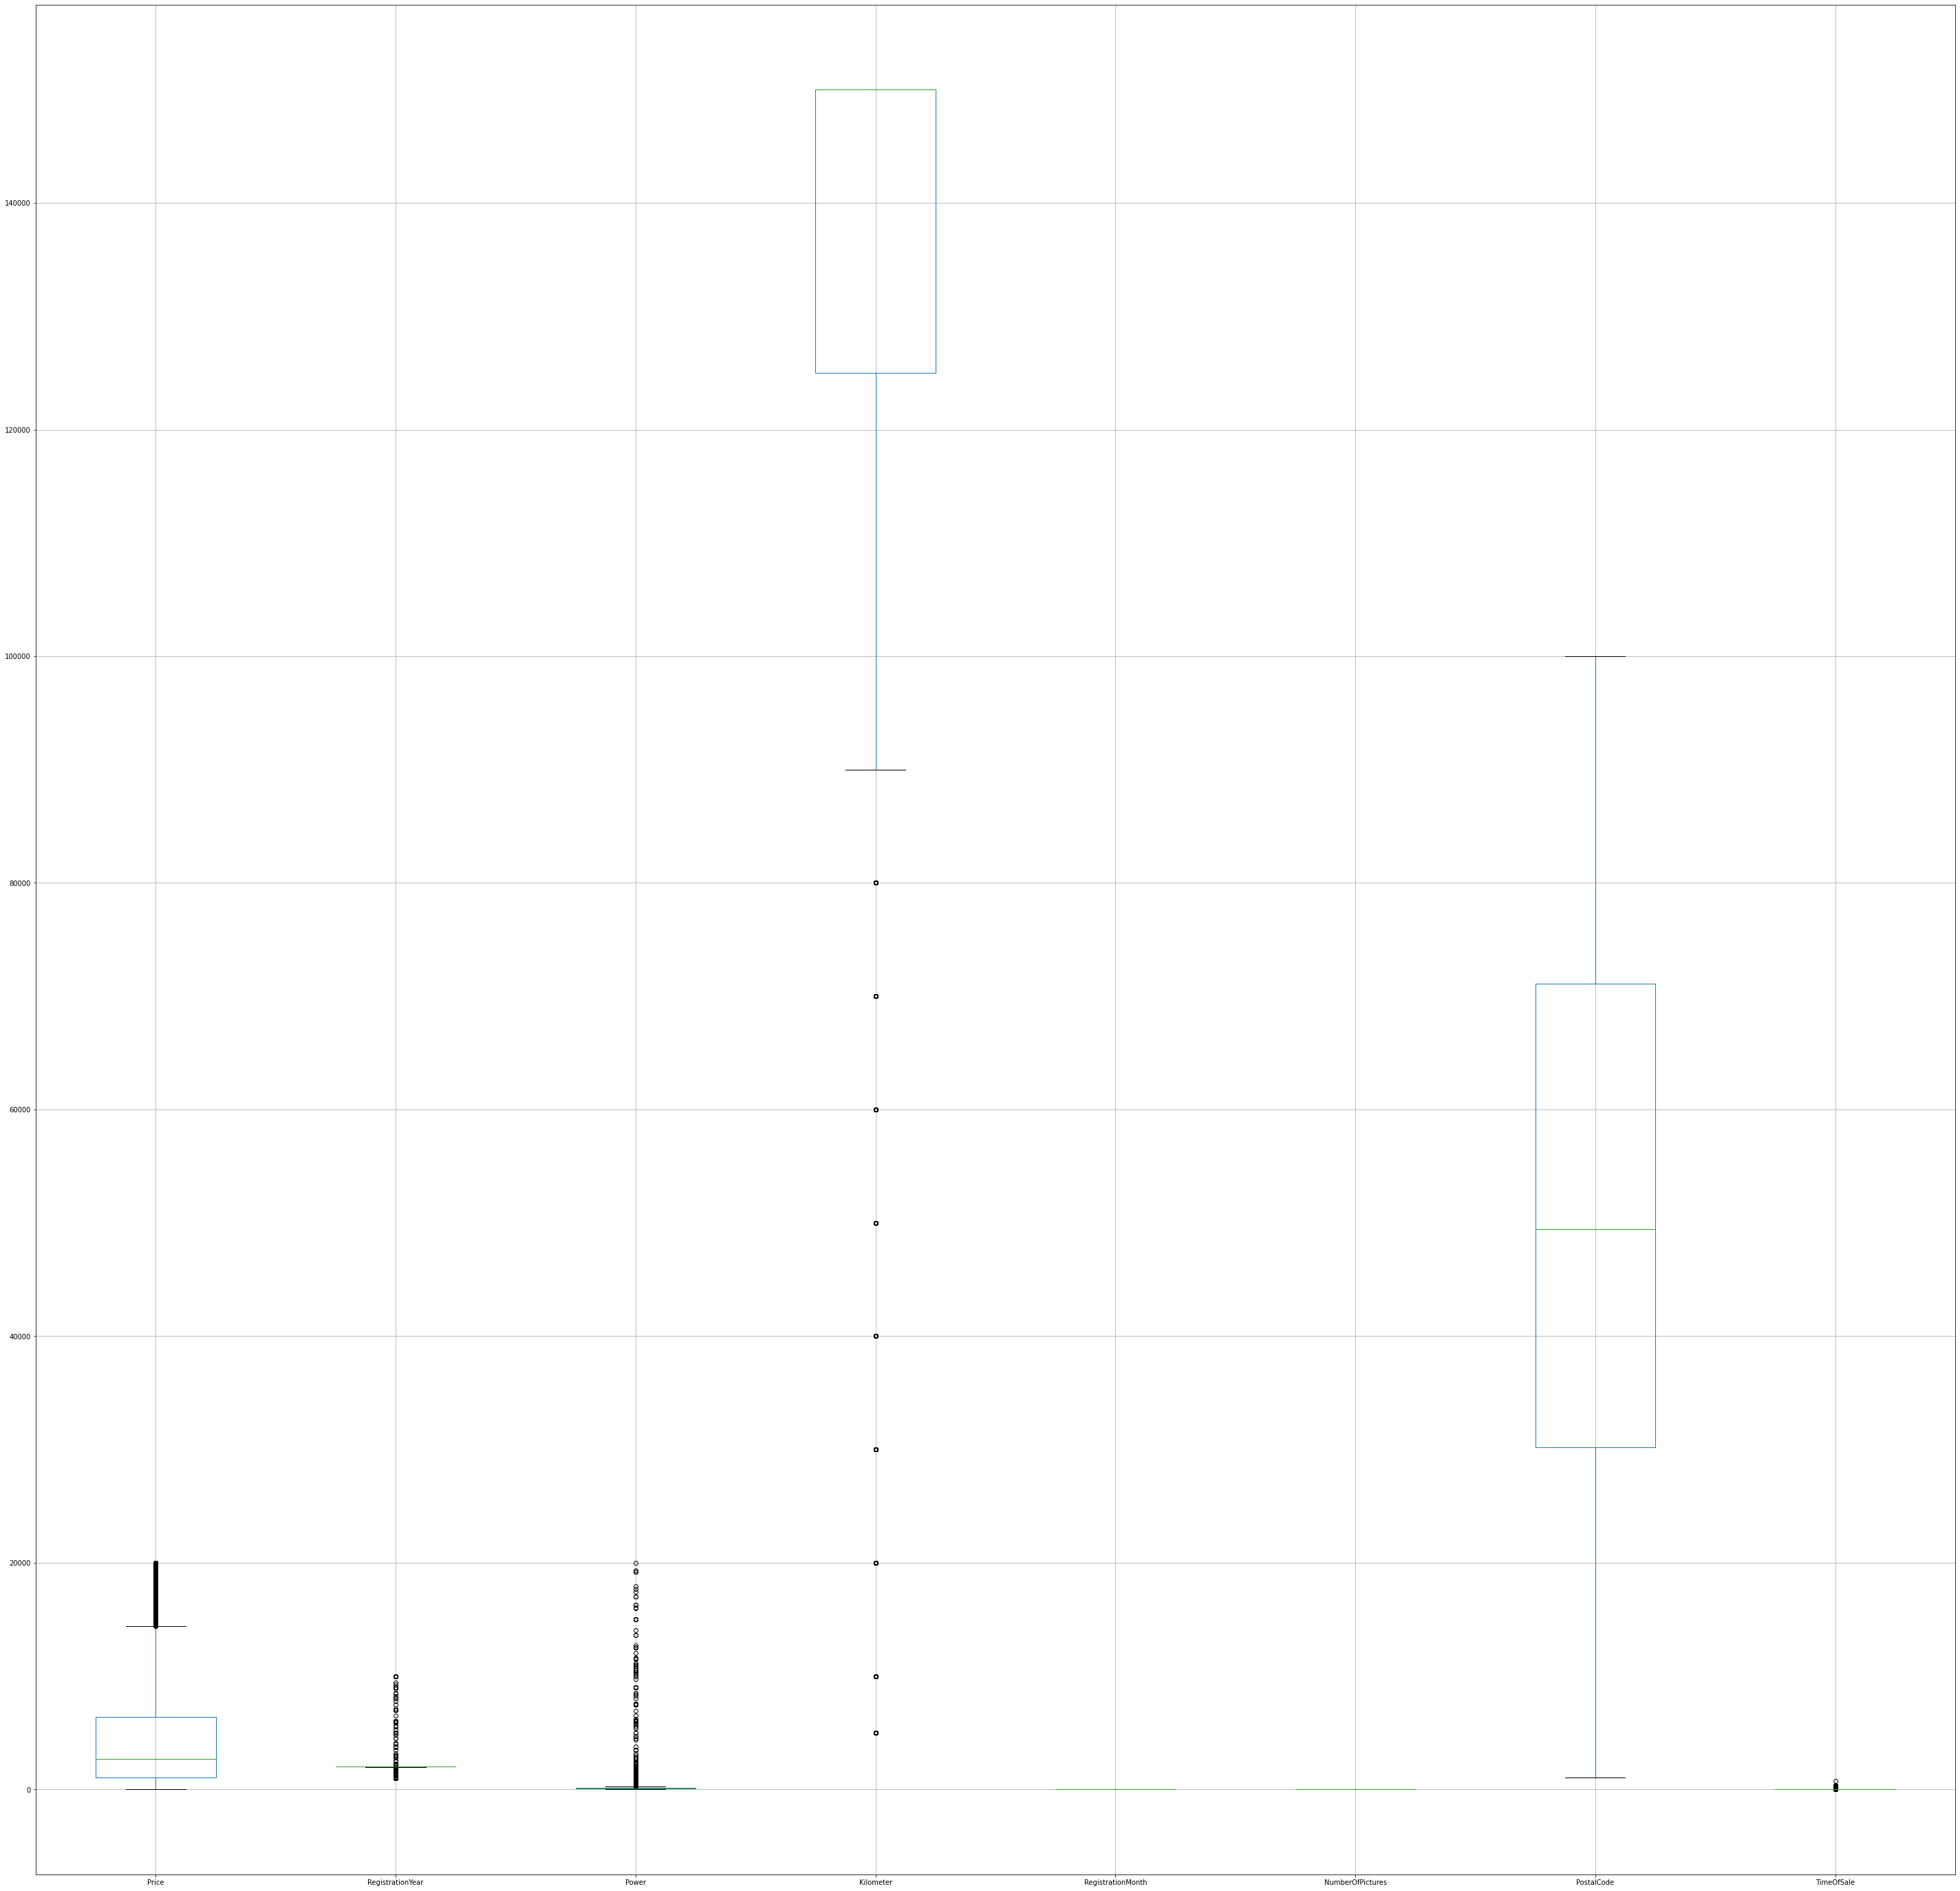

In [14]:
data.boxplot(figsize=(50, 50));

<div style="border: 5px solid violet; border-radius: 5px;">
Столбец с количеством фото не подгрузился, удалим его. Также удалим столбцы, которые нам не нужны. Избавимся от неадекватных объектов в виде цены 0. Также избавимся от аномалий и технического столбца со временем продаж. Перед этим в базе оставим только те объекты, которые продались за 100 дней(по правде 30)
</div>

In [15]:
data['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

In [16]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

In [17]:
print(data['Price'].value_counts())
data = data[data['Price'] != 0]

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64


In [18]:
data = data[data['Power'] <= 1000]
data = data[data['TimeOfSale'] <= 100]

In [19]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,TimeOfSale
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,15
1,18300,coupe,2011,manual,190,NaN,125000,petrol,audi,yes,15
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN,23
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,7


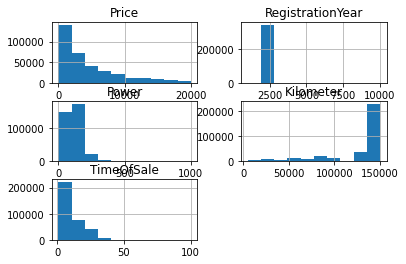

In [20]:
data.hist();

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343289 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343289 non-null  int64 
 1   VehicleType       309582 non-null  object
 2   RegistrationYear  343289 non-null  int64 
 3   Gearbox           325952 non-null  object
 4   Power             343289 non-null  int64 
 5   Model             325803 non-null  object
 6   Kilometer         343289 non-null  int64 
 7   FuelType          313885 non-null  object
 8   Brand             343289 non-null  object
 9   Repaired          277528 non-null  object
 10  TimeOfSale        343289 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 31.4+ MB


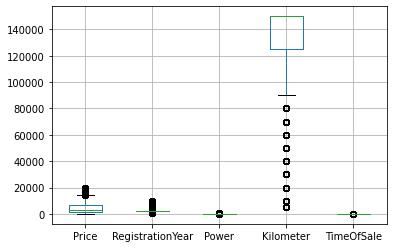

In [22]:
data.boxplot();

In [23]:
data = data.drop(['TimeOfSale'], axis=1)

In [24]:
# КОД РЕВЬЮЕРА
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,343289.000000,343289.000000,343289.000000,343289.000000
mean,4556.134927,2004.083766,107.620961,128341.514001
std,4515.700601,78.251382,63.733085,37513.180301
min,1.000000,1000.000000,0.000000,5000.000000
25%,1200.000000,1999.000000,69.000000,125000.000000
50%,2890.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,1000.000000,150000.000000


In [25]:
data['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1500, 1600, 1602, 1800,
       1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290,
       2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800,
       5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7800,
       8000, 8200, 8500, 8888, 9000, 9450, 9999])

In [26]:
data = data[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1910)]

In [27]:
# КОД РЕВЬЮЕРА
data.duplicated().sum()

43099

In [28]:
print(data.duplicated().sum())
data = data.drop_duplicates()

43099


In [29]:
data.shape

(286382, 10)

In [30]:
# КОД РЕВЬЮЕРА
data.isna().sum()

Price                   0
VehicleType         18670
RegistrationYear        0
Gearbox             13734
Power                   0
Model               14837
Kilometer               0
FuelType            23010
Brand                   0
Repaired            54548
dtype: int64

In [31]:
data = data.fillna('UNKNOWN', axis=0)
print(data.isna().sum())
data.shape

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64


(286382, 10)

In [32]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,UNKNOWN,1993,manual,0,golf,150000,petrol,volkswagen,UNKNOWN
1,18300,coupe,2011,manual,190,UNKNOWN,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,UNKNOWN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


In [33]:
data_ohe = pd.get_dummies(data, drop_first=True)

<div style="border: 5px solid violet; border-radius: 5px;">
Разобьем на выборки, для корректного обучения и проверки модели, в соотношении 3:1:1
</div>

In [35]:
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)
features_work, features_test, target_work, target_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)
features_train, features_valid, target_train, target_valid = train_test_split(features_work, target_work, test_size=0.25, random_state=RANDOM_STATE)
print(features_work.shape, target_work.shape)
print(features_test.shape, target_test.shape)
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(229105, 310) (229105,)
(57277, 310) (57277,)
(171828, 310) (171828,)
(57277, 310) (57277,)
(57277, 310) (57277,)


In [36]:
#cat_features = ['VehicleType', 'FuelType', 'Gearbox', 'Brand', 'Model']

#ohe_encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

#train_temp = ohe_encoder.fit_transform(features_train[cat_features]) # обучили на трейне и сразу к нему применили
#features_train[ohe_encoder.get_feature_names()] = train_temp # вписали новые признаки
#features_train.drop(cat_features, axis=1, inplace=True) # удалили старые признаки

#test_temp = ohe_encoder.transform(features_test[cat_features]) # обученный энкодер применили к тест. выборке
#features_test[ohe_encoder.get_feature_names()] = test_temp # вписали новые признаки
#features_test.drop(cat_features, axis=1, inplace=True) # удалили старые признаки

#features_test.head()

In [37]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


/tmp/ipykernel_332/513222539.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_332/513222539.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [38]:
display(features_train.head())
display(features_valid.head())
display(features_test.head())

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_UNKNOWN,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_1,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_yes
18639,0.196118,-0.296292,-1.487206,0,0,

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_UNKNOWN,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_1,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_yes
180390,-4.444964,-0.920856,-1.487206,0,

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_auto,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_UNKNOWN,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_1,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_cng,FuelType_electric,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_yes
167334,-0.647715,-0.530503,0.599638,0,0

## Обучение моделей

<div style="border: 5px solid violet; border-radius: 5px;">
Первой моделью будет линейная регрессия в силу её простоты и скорости.
</div>

In [39]:
%%time

model_lin = LinearRegression()
model_lin.fit(features_train, target_train)
predict_lin = model_lin.predict(features_valid)

CPU times: user 15.8 s, sys: 18.3 s, total: 34.1 s
Wall time: 1min 39s


In [40]:
mean_squared_error(predict_lin, target_valid) ** 0.5

2818.6080345102546

<div style="border: 5px solid violet; border-radius: 5px;">
Смысла перебирать гиперпараметры здесь не вижу. Высокая скорость обучения, но метрика превышает нужный нам предел на порядки.
</div>

<div style="border: 5px solid violet; border-radius: 5px;">
Далее - случайный лес.
Автоматическим перебором он считал у меня 20 минут - я издеваться не буду, закомментировал.
Он выдал мне всё равно начальные параметры - 100, gini, 10 - как будто ничего не делал. 
Я просто вызвал потом случайный лес с данными параметрами.
</div>

In [42]:
#%%time

#model_forest = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=100, n_estimators=100)
#model_forest.fit(features_train, target_train)
#predict_forest = model_forest.predict(features_valid)
#mean_squared_error(predict_forest, target_valid) ** 0.5

<div style="border: 5px solid violet; border-radius: 5px;">
Далее у нас будет - LightGBM. Сократил n_estimators до 10, так как по какой-то причине, без изменений n_job он стал оооочень долго считать.
</div>

In [43]:
%%time
booster = lgb.LGBMModel(objective="regression", n_estimators=10, verbose=100, random_state=RANDOM_STATE)

booster.fit(features_train, target_train, eval_set=[(features_valid, target_valid),], eval_metric="rmse")

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.912474
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.594770
[LightGBM] [Debug] init for col-wise cost 2.747640 seconds, init for row-wise cost 2.536222 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.520880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 171828, number of used features: 290
[LightGBM] [Info] Start training from score 4678.588292
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[1]	valid_0's rmse: 4274.85	valid_0's l2: 1.82743e+07
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[2]	valid_0's rmse: 3989.85	valid_0's l2: 1.59189e+07
[LightGBM] [Debug] Trained a tree with leaves 

LGBMModel(n_estimators=10, objective='regression', random_state=12345,
          verbose=100)

In [44]:
%%time

parametrs_cat = {'n_estimators': range(100, 1101, 500),
                 'learning_rate': [0.03, 0.1]
                }
model_cat = CatBoostRegressor(random_state=RANDOM_STATE)
grid_cat = GridSearchCV(model_cat, parametrs_cat, cv=3)

CPU times: user 175 µs, sys: 0 ns, total: 175 µs
Wall time: 179 µs


In [ ]:
%%time
grid_cat.fit(features_train, target_train)

0:	learn: 4511.8894507	total: 421ms	remaining: 41.7s
1:	learn: 4428.1484572	total: 658ms	remaining: 32.3s
2:	learn: 4347.2478267	total: 826ms	remaining: 26.7s
3:	learn: 4268.6321246	total: 1.01s	remaining: 24.2s
4:	learn: 4191.2375769	total: 1.21s	remaining: 23s
5:	learn: 4118.7898442	total: 1.37s	remaining: 21.5s
6:	learn: 4049.9190835	total: 1.52s	remaining: 20.2s
7:	learn: 3979.5343694	total: 1.64s	remaining: 18.9s
8:	learn: 3914.5230029	total: 1.76s	remaining: 17.8s
9:	learn: 3853.5189132	total: 2.04s	remaining: 18.4s
10:	learn: 3792.4012733	total: 2.3s	remaining: 18.6s
11:	learn: 3732.3992043	total: 2.56s	remaining: 18.8s
12:	learn: 3676.6708585	total: 2.87s	remaining: 19.2s
13:	learn: 3620.3758626	total: 3.05s	remaining: 18.7s
14:	learn: 3565.7472578	total: 3.07s	remaining: 17.4s
15:	learn: 3515.4148262	total: 3.18s	remaining: 16.7s
16:	learn: 3467.4999160	total: 3.36s	remaining: 16.4s
17:	learn: 3419.3195546	total: 3.53s	remaining: 16.1s
18:	learn: 3373.6205260	total: 3.71s	rema

In [ ]:
%%time

cat = CatBoostRegressor(random_state=RANDOM_STATE, **grid_cat.best_params_)
cat.fit(features_train,target_train, plot=True, verbose=False)

In [ ]:
%%time
predict_cat = cat.predict(features_valid)
mean_squared_error(predict_cat, target_valid) ** 0.5

<div style="border: 5px solid violet; border-radius: 5px;">
Можно подводить итоги.
</div>

## Анализ моделей

<div style="border: 5px solid violet; border-radius: 5px;">
    
* Линейная регрессия выбыла - хорошая скорость, но другие модели демонстрировали метрики лучше на валидации и обучении.
    
* Случайный лес - относительно среднее качество на тренировочной выборке, но долгое время обучения. При этом автоматический подбор гиперпараметров занимает много времени. + в связке с LightGBM кладёт ядро kernel.
    
* LightGBM - скорость демонстрирует нестабильную, в связке со случайным лесом кладёт ядро kernel. Качество хорошее, но рулетка, просто технически невозможно иногда за адекватное время прийти к нужным метрикам.
    
* CatBoost - первая по качеству, время обучения сопоставимо или быстрее в 2 раза со случайным лесом, но при этом осуществлялся подбор гиперпараметров, что на мой взгляд важно, учитывая что лес и LightGBM просто легли, не говоря об автоматизации. 
    
Я остановлюсь на CatBoost из-за высокой скорости обучения, лучшего качества и стабильности, хоть и не требовалось этого.
    
Время предсказания не рассматривал, в силу незначительности этой характеристики, не заметно на фоне обучения.
    
RMSE ниже 2500 удалось достичь на тесте.
</div>

In [ ]:
%%time
predict_cat_test = cat.predict(features_test)
mean_squared_error(predict_cat_test, target_test) ** 0.5